In [20]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import sys
sys.path.append("/code/LLM-crime/single_model")
sys.path.append("/code/LLM-crime")
from LLM_feature_extractor import LLaVaFeatureExtractor
from safety_train_new import Extractor, Adaptor, Classifier, FullModel

from glob import glob
from PIL import Image
import torchvision.transforms as transforms
from safety_perception_dataset import *
import neptune
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import r2_score
import shutil
from itertools import product
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"


## multimodal

In [21]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import sys
sys.path.append("/code/LLM-crime/single_model")
sys.path.append("/code/LLM-crime")
from LLM_feature_extractor import LLaVaFeatureExtractor
from multimodal_safety_train import ImageExtractor, TextExtractor, Adaptor, Classifier, Mixer, MultiModalModel

import pandas as pd
from glob import glob
from PIL import Image
import torchvision.transforms as transforms
# from safety_perception_dataset import *
import neptune
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import r2_score
import shutil
from itertools import product
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torch.utils.data import Dataset
import transformers
import numpy as np

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [22]:
class MultimodalSafetyPerceptionDataset(Dataset):
    def __init__(self, data, tokenizer=None, transform=None, paras=None,SVI_type='placepulse'):
        """
        Args:
            data (list or np.array): List or array of data samples.
            labels (list or np.array): List or array of labels corresponding to the data samples.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.captions = list(self.data['text_description_short'])   
        if tokenizer == 'Bert':
            self.tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
        elif tokenizer == 'GPT2':
            self.tokenizer = transformers.GPT2Tokenizer.from_pretrained('gpt2')
        elif tokenizer == 'DistilBert':
            self.tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

        self.transform = transform
        # self.img_path = "/data2/cehou/LLM_safety/PlacePulse2.0/photo_dataset/final_photo_dataset/"

        self.paras = paras
        self.SVI_type = SVI_type
        if SVI_type == 'GSV':
            self.img_path = "/data2/cehou/LLM_safety/GSV/HK_imgs"
        elif SVI_type == 'Stockholm':
            self.img_path = "/data2/cehou/LLM_safety/Stockholm/GSV_5000_2/"
        elif SVI_type == 'placepulse':
            self.img_path = "/data2/cehou/LLM_safety/PlacePulse2.0/photo_dataset/final_photo_dataset/"
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):        
        # image = np.array(Image.open(f"{self.img_path}/{self.data.iloc[idx]['Image_ID']}.jpg"))
        # image = Image.fromarray(image)
        if self.SVI_type == 'placepulse':
            image_path = f"{self.img_path}/{self.data.iloc[idx]['Image_ID']}.jpg"
            image = np.array(Image.open(f"{self.img_path}/{self.data.iloc[idx]['Image_ID']}.jpg"))
        elif self.SVI_type == 'Stockholm':
            image_path = f"{self.img_path}/{self.data.iloc[idx]['Image_ID']}.jpg"
            image = np.array(Image.open(f"{self.img_path}/{self.data.iloc[idx]['Image_ID']}.jpg"))
            
        elif self.SVI_type == 'GSV':
            image_id = self.data.iloc[idx]['Image_ID']
            for i,angle in enumerate([0, 90, 180, 270]):
                image_path = f"{self.img_path}/{image_id[0]}/{image_id[1]}/{image_id}_{angle}.jpg"
                if i == 0:
                    image = np.array(Image.open(image_path))
                else:
                    image = np.concatenate((image, np.array(Image.open(image_path))), axis=1)
        image = Image.fromarray(image)
        if self.paras['train_type'] == 'classification':
            label = self.data.iloc[idx]["label"]
            # label = label * 100 // 5
        elif self.paras['train_type'] == 'regression':
            label = self.data.iloc[idx]["Score"]
            
        if self.transform:            
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        tokenized_text = self.tokenizer(
            self.data.iloc[idx]["text_description_short"], padding=True, truncation=True, max_length=512
        )
        encoded_descriptions =  torch.tensor(tokenized_text['input_ids']).float() 
        attention_mask = torch.tensor(tokenized_text['attention_mask']).float()
        # Pad the sequence with zeros to make it 512 in length

        padding_length = 512 - len(encoded_descriptions)
        if padding_length > 0:
            encoded_descriptions = torch.cat((encoded_descriptions, torch.zeros(padding_length)), dim=0)
            attention_mask = torch.cat((attention_mask, torch.zeros(padding_length)), dim=0)
        elif padding_length < 0:
            encoded_descriptions = encoded_descriptions[:512]
            attention_mask = attention_mask[:512]

        # encoded_descriptions转换为long
        # encoded_descriptions = torch.nn.Linear(encoded_descriptions.size(0), 512)(encoded_descriptions)

        return image, (encoded_descriptions, attention_mask), label


def get_transforms(resize_size):
    return transforms.Compose(
        [
            transforms.Resize((resize_size[0], resize_size[1])),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )    


def multimodal_model_test(model, test_loader, LLM_model=None):
    if LLM_model is not None:
        LLM_pre_extractor = LLM_model
    model.eval()  # 切换到评估模式
    all_preds = []
    all_outputs = []
    all_labels = []

    with torch.no_grad():  # 关闭梯度计算，节省内存
        for data, (description, attention_mask), target in tqdm(test_loader):
            if LLM_model is not None:
                data = LLM_pre_extractor([data[i] for i in range(len(data))])
            data, description, attention_mask, target = data.cuda(), description.cuda().long(), attention_mask.cuda().long(), target.cuda().long()
            output = model(data, description, attention_mask)  # 获取模型输出
            _, predicted = torch.max(output.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_outputs.append(output)
    
    all_outputs = torch.cat(all_outputs, dim=0)
    
    # 计算混淆矩阵
    # cm = confusion_matrix(all_labels, all_preds)
    # # 计算F1分数
    # f1 = f1_score(all_labels, all_preds, average='weighted')
    return all_outputs, all_labels


In [23]:
# class ImageFeatureGenerater(nn.Module):
#     def __init__(self, image_extractor, image_adaptor):
#         super(ImageFeatureGenerater, self).__init__()
#         self.image_extractor = image_extractor
#         self.image_adaptor = image_adaptor

#     def forward(self, x_img):
#         # 先通过extractor提取特征，再通过adaptor处理，最后分类
#         img_features = self.image_extractor(x_img)
#         adapted_img_features = self.image_adaptor(img_features)
#         return adapted_img_features

# class TextFeatureGenerater(nn.Module):
#     def __init__(self, text_extractor, text_adaptor):
#         super(TextFeatureGenerater, self).__init__()
#         self.text_extractor = text_extractor
#         self.text_adaptor = text_adaptor

#     def forward(self, x_text, attention_mask):
#         # 先通过extractor提取特征，再通过adaptor处理，最后分类
#         text_features = self.text_extractor(x_text, attention_mask)
#         adapted_text_features = self.text_adaptor(text_features)
#         return adapted_text_features

# image_feature_generater = ImageFeatureGenerater(image_extractor, image_adaptor)
# text_feature_generater = TextFeatureGenerater(text_extractor, text_adaptor)

# image_feature_generater.load_state_dict(torch.load(model_path, map_location='cuda:0'), strict=False)
# text_feature_generater.load_state_dict(torch.load(model_path, map_location='cuda:0'), strict=False)

In [26]:
# specific_groups = [
#     "30_female",
#     "60_female",
#     "30_male",
#     "60_male",
# ]

# specific_groups = [
#     "60_male_HongKong_traffic accident_GSV",
#     "60_female_HongKong_traffic accident_GSV",
#     "30_male_HongKong_traffic accident_GSV",
#     "30_female_HongKong_traffic accident_GSV"
# ]

specific_groups = [
    "60_male_HongKong_traffic accident_GSV_other_crime",
    "60_female_HongKong_traffic accident_GSV_other_crime"
]

all_round_outputs = []
all_round_labels = []

for specific_group in specific_groups:
    print(specific_group)
    root_path = f"/data2/cehou/LLM_safety/LLM_models/safety_perception_model/multimodal/pseudo_label_from_pretrain_20250108/model_{specific_group}/"

    parameters_path = glob(f"{root_path}/round_1/*.csv")[0]
    parameters = pd.read_csv(parameters_path)
    parameters.drop(["Unnamed: 0"], axis=1, inplace=True)
    parameters = parameters.iloc[0].to_dict()


    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    # placepulse_data = pd.read_csv("/data2/cehou/LLM_safety/img_text_data/baseline/tidyed/dataset_baseline_baseline_baseline_baseline_9030_withlabel.csv")
    # placepulse_data['label'] = 1
    # placepulse_data = placepulse_data.rename(columns={"panoid": "Image_ID"})
    # data_name = f"dataset_30_{specific_group.split('_')[1]}_HongKong_theft or harassment_GSV"
    data_name = f"dataset_{specific_group[:-12]}"
    pkl_path = glob(f"/data2/cehou/LLM_safety/img_text_data/finished/{data_name}_*.pkl")[0]
    data = pd.read_pickle(pkl_path)

    transform = get_transforms((224,224))
    data = data.rename(columns={'text_description_gender': 'text_description_short',
                                                'panoid': 'Image_ID',})
    data['label'] = 1
    total_dataset = MultimodalSafetyPerceptionDataset(data, tokenizer=parameters['text_feature_extractor'], transform=transform, paras=parameters, SVI_type="GSV")
    total_loader = torch.utils.data.DataLoader(total_dataset, batch_size=parameters['batch_size'])

    model_path = glob(f"{root_path}/round_1/*.pt")[0]

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    image_extractor = ImageExtractor(pretrained_model=parameters['visual_feature_extractor']) # [128, 512]
    text_extractor = TextExtractor(pretrained_model=parameters['text_feature_extractor']) # [128, 768]
    image_adaptor = Adaptor(input_dim=parameters['image_input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='image') # [128, 256]
    text_adaptor = Adaptor(input_dim=parameters['text_input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='text') # [128, 256]
    mixer = Mixer(output_dim=parameters['mixer_output_dim'], process=parameters['mix_process']) # [128, 512]
    classifier = Classifier(input_dim=parameters['mixer_output_dim'], num_classes=parameters['num_classes']) # [128, 2]

    multimodal_model = MultiModalModel(image_extractor, text_extractor, image_adaptor, text_adaptor, mixer, classifier).to(device)

    # Load the saved model parameters
    multimodal_model.load_state_dict(torch.load(model_path, map_location='cuda:0'), strict=False)

    multimodal_model.eval()  # 切换到评估模式

    all_outputs, all_labels = multimodal_model_test(multimodal_model, total_loader)
    
    all_round_outputs.append(all_outputs)
    all_round_labels.append(all_labels)

60_male_HongKong_traffic accident_GSV_other_crime


100%|██████████| 39/39 [01:24<00:00,  2.17s/it]


60_female_HongKong_traffic accident_GSV_other_crime


100%|██████████| 37/37 [01:21<00:00,  2.21s/it]


In [151]:
data.iloc[0]['text_description_gender']

'When evaluating the safety perception of specific criminal behaviors, it is important to consider the sensitivity of different demographic groups to their environment. For females, certain aspects of the image may be more relevant and impactful on their perception of safety.\n\n1. **Visibility**: Females may be more concerned about visibility, especially at night or in poorly lit areas. In the image, there are streetlights that can provide better visibility and reduce the risk of accidents.\n\n2. **Pedestrian Crossings**: Females may be more cautious when crossing streets, especially if they are alone. In the image, there is a pedestrian crossing, which can provide a sense of security for females.\n\n3. **Parking and Traffic Flow**: The way vehicles are parked and the flow of traffic can impact safety. In the image, there are parked vehicles on the side of the road, which can influence how females navigate the area.\n\n4. **Weather Conditions**: Weather conditions can affect visibilit

In [152]:
# all_round_outputs = []
# all_round_labels = []
# for i in range(1,6):
#     model_path = glob(f"{root_path}/round_1/*.pt")[0]

#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     image_extractor = ImageExtractor(pretrained_model=parameters['visual_feature_extractor']) # [128, 512]
#     text_extractor = TextExtractor(pretrained_model=parameters['text_feature_extractor']) # [128, 768]
#     image_adaptor = Adaptor(input_dim=parameters['image_input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='image') # [128, 256]
#     text_adaptor = Adaptor(input_dim=parameters['text_input_dim'], projection_dim=parameters['adaptor_output_dim'], data_type='text') # [128, 256]
#     mixer = Mixer(output_dim=parameters['mixer_output_dim'], process=parameters['mix_process']) # [128, 512]
#     classifier = Classifier(input_dim=parameters['mixer_output_dim'], num_classes=parameters['num_classes']) # [128, 2]

#     multimodal_model = MultiModalModel(image_extractor, text_extractor, image_adaptor, text_adaptor, mixer, classifier).to(device)

#     # Load the saved model parameters
#     multimodal_model.load_state_dict(torch.load(model_path, map_location='cuda:0'), strict=False)

#     multimodal_model.eval()  # 切换到评估模式

#     all_outputs, all_labels = multimodal_model_test(multimodal_model, total_loader)
    
#     all_round_outputs.append(all_outputs)
#     all_round_labels.append(all_labels)

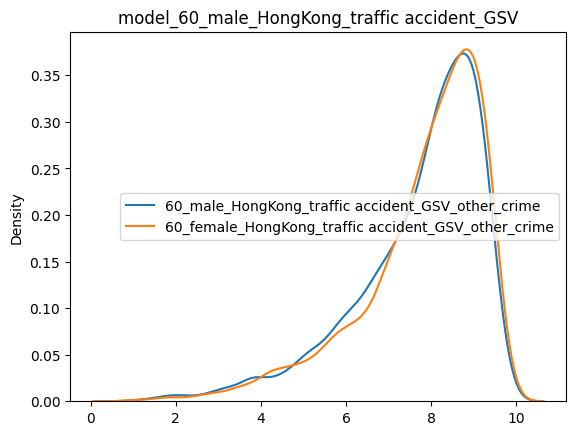

In [27]:
all_round_score = [F.softmax(all_outputs, dim=1) for all_outputs in all_round_outputs]
all_final_outputs = []

for i,round_score in enumerate(all_round_score):
    final_outputs = round_score[:,0]* 0 + round_score[:,1] * 10
    final_outputs = final_outputs.cpu().numpy()
    all_final_outputs.append(final_outputs)
    sns.kdeplot(final_outputs, label=f"{specific_groups[i]}")

plt.title("model_60_male_HongKong_traffic accident_GSV")
plt.legend()

In [33]:
# specific_groups = [f"60_female_HongKong_theft or harassment_GSV"]
for idx in range(2):
    print(specific_groups[idx])
    female_metadata_path = glob(f"/data2/cehou/LLM_safety/img_text_data/finished/dataset_{specific_groups[idx][:-12]}_*.pkl")[0]
    metadata = pd.read_pickle(female_metadata_path)
    all_round_score = [F.softmax(all_outputs, dim=1) for all_outputs in all_round_outputs]
    final_outputs = all_round_score[idx][:,0]* 0 + all_round_score[idx][:,1] * 10
    final_outputs = final_outputs.cpu().numpy()
    if idx == 0:
        total_df = pd.concat([metadata, pd.DataFrame(final_outputs, columns=['Score'])],axis=1)
    else:
        tem = pd.concat([metadata, pd.DataFrame(final_outputs, columns=['Score'])],axis=1)
        total_df = pd.concat([total_df, tem],axis=0)
    print(total_df.shape)

60_male_HongKong_traffic accident_GSV_other_crime
(4956, 11)
60_female_HongKong_traffic accident_GSV_other_crime
(9639, 11)


In [34]:
total_df

,GSV_idx,panoid,age,gender,location,event,text_description_all,text_description_age,text_description_gender,text_description_location,Score
0,0,LhDzohF2sf0z5MOC8WvTlw,60,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For people in the age of 60, several factors i...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...,5.796052
1,1,viTmwnbfW4rJ67N4uqhqDw,60,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For people in the age of 60, several factors i...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...,8.876193
2,2,Zkc3vyAoKoOpvvvw-HChog,60,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For people in the age of 60, several factors i...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...,4.481764
3,3,O4e3zJoSZrUzeN-FIJk6Yg,60,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For people in the age of 60, several factors i...",When evaluating the safety perception of speci...,When discussing the safety perception in Hong ...,8.770381
4,4,QxlvY42Xl-2J_wuSQfbIKA,60,male,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For people in the age of 60, several factors i...",When evaluating the safety perception of speci...,When discussing the safety perception in Hong ...,8.970701
...,...,...,...,...,...,...,...,...,...,...,...
4678,3739,i6w_o1zBHoryi6i2x8u8gg,60,female,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For people in the age of 60, several factors i...",When evaluating the safety perception of speci...,The built environment in Hong Kong is characte...,5.644323
4679,3740,viuojyipnZ6VteapVYRiQA,60,female,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For people in the age of 60, several factors i...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...,6.369167
4680,3741,Ze2JVZ9bLEMbaMv5nnP-4A,60,female,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For people in the age of 60, certain factors i...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...,8.230130
4681,3742,aPXIN1EpbwKnjUDV-smlNw,60,female,HongKong,traffic accident,"[[INST] \n[""Please design a car accident-focu...","For people in the age of 60, several factors i...",When evaluating the safety perception of speci...,Hong Kong is a densely populated urban area wi...,7.199415


In [35]:
total_df.to_pickle(f"/data2/cehou/LLM_safety/img_text_data/mapping/older_crime.pkl")

In [42]:
total_df = pd.read_pickle(f"/data2/cehou/LLM_safety/img_text_data/mapping/crime_all.pkl")

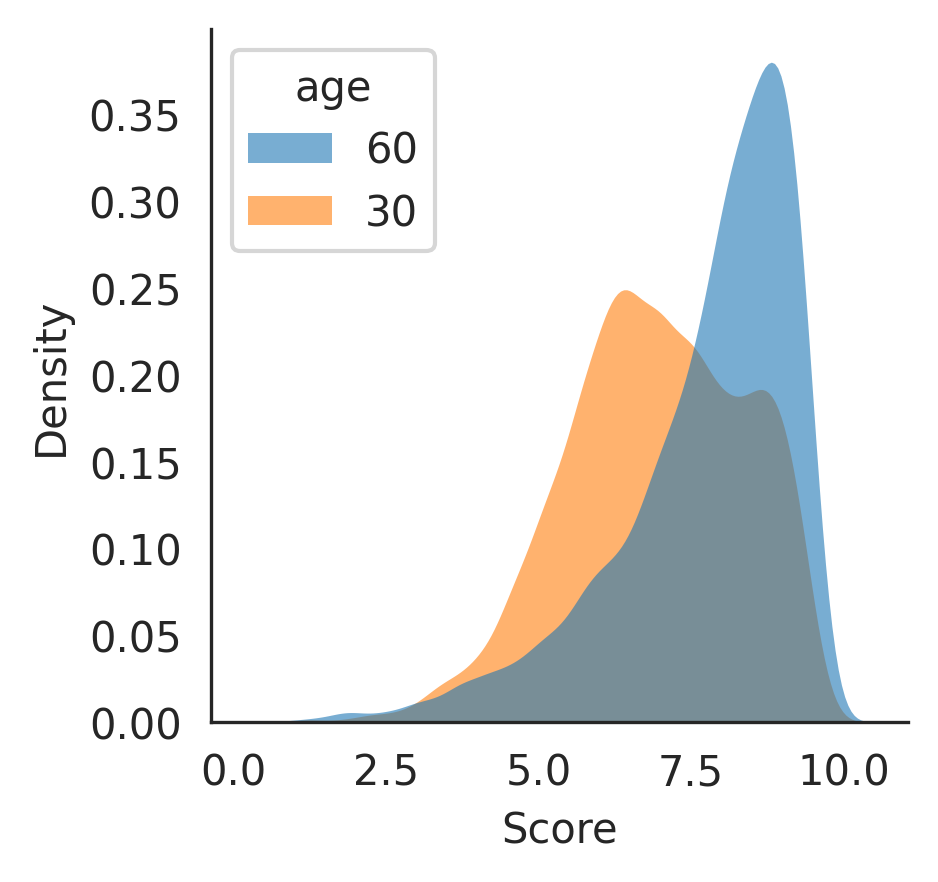

In [44]:
# sns.kdeplot(total_df, x='Score', hue='gender', multiple="stack")
sns.set_style("white")
# plt.rcParams['font.sans-serif'] = ['Times New Roman']
fig, ax = plt.subplots(figsize=(3,3),dpi=300)
sns.kdeplot(
   data=total_df, x="Score", hue="age",
   fill=True, common_norm=False,
   alpha=.6, linewidth=0,ax=ax, legend=True
)

sns.move_legend(ax, "upper left")
sns.despine(ax=ax, top=True, right=True)
# plt.legend(loc='upper left')



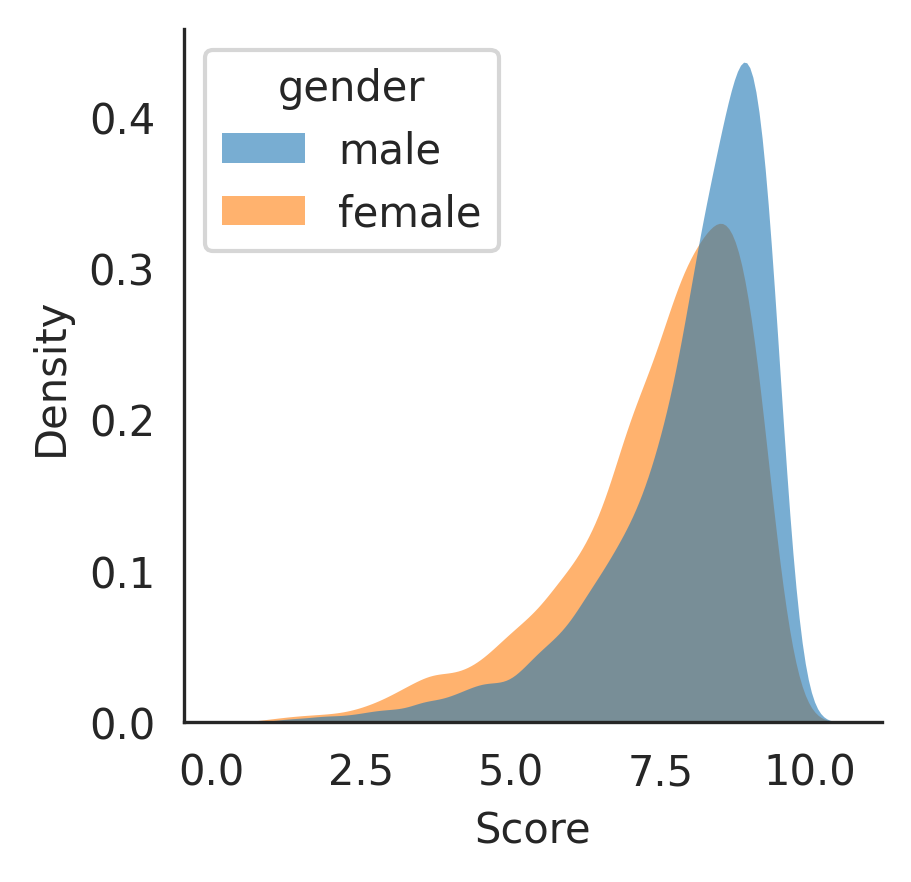

In [144]:
# sns.kdeplot(total_df, x='Score', hue='gender', multiple="stack")
sns.set_style("white")
# plt.rcParams['font.sans-serif'] = ['Times New Roman']
fig, ax = plt.subplots(figsize=(3,3),dpi=300)
sns.kdeplot(
   data=total_df[total_df['age'] == '60'], x="Score", hue="gender",
   fill=True, common_norm=False,
   alpha=.6, linewidth=0,ax=ax, legend=True
)

sns.move_legend(ax, "upper left")
sns.despine(ax=ax, top=True, right=True)
# plt.legend(loc='upper left')



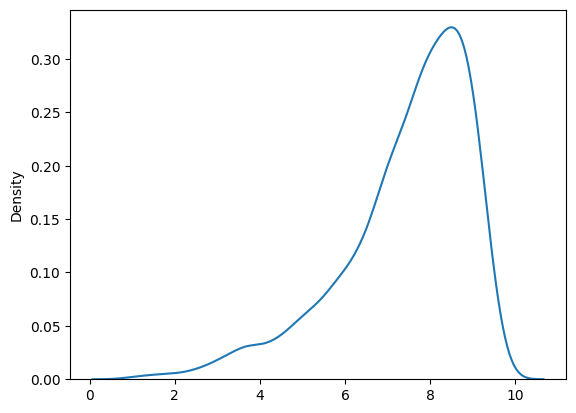

In [104]:
sns.kdeplot(final_outputs, label=f"{specific_groups[idx]}")
# plt.legend()
plt.show()

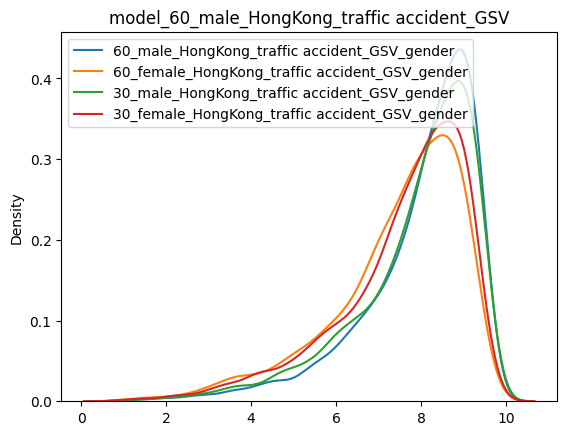

In [75]:
all_round_score = [F.softmax(all_outputs, dim=1) for all_outputs in all_round_outputs]
all_final_outputs = []

for i,round_score in enumerate(all_round_score):
    final_outputs = round_score[:,0]* 0 + round_score[:,1] * 10
    final_outputs = final_outputs.cpu().numpy()
    all_final_outputs.append(final_outputs)
    sns.kdeplot(final_outputs, label=f"{specific_groups[i]}")

plt.title("model_60_male_HongKong_traffic accident_GSV")
plt.legend()